# Multi-agent, multimodal system

This notebook consists in an adaptation of the Child-Tutoring Project at the Okinawa Institute of Science and Technology. 
It can be run directly from beginning to end, which would illustrate how the system works.
Since in this adaptation we have no camera and no robot, these have been substituted by a few images, similar to what the system would have processed during the real interactions, and an in-image pointing tool replacing the robotic arm, correspondingly.

#### Imports

In [4]:
import os
import functools
from collections import deque 
from IPython.display import Image, display, Markdown
import supervision
import sqlite3

# LangChain imports
from langchain_core.tools import tool
from langchain_openai.chat_models import ChatOpenAI
import langchain_core.messages.human
import langchain_core.messages.ai
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph

# Anthropic import
import anthropic

# Local imports
from utils import (
    get_openai_api_key, get_anthropic_api_key, get_tavily_api_key,
    yolo_for_llm_lst, lmm_no_blocks, llm_interpret_yolo, llm_summarize,
    create_chatbot, chatbot_node, llm_combine_all, State, BasicToolNode,
    route_tools, text_to_speech, arrow_point
)
import voice_recog

Access to various APIs

In [5]:
OPENAI_API_KEY = get_openai_api_key()
ANTHROPIC_API_KEY = get_anthropic_api_key()
anthropic_client = anthropic.Anthropic()
TAVILY_API_KEY = get_tavily_api_key()

Simulate camera, by calling each time some consecutive images

In [6]:
image_dir = os.path.join(os.getcwd(), "task_images_tiny")
image_files = os.listdir(image_dir)
image_files.sort(key=lambda x: int(x.split(".")[0].split("_")[-1]))
image_deque = deque([os.path.join(image_dir, img) for img in image_files])
def get_current_image(): 
    return image_deque.popleft()

# Visual processing

#### The main task demanded a perfect "understanding" of the spatial relationships between the colored blocks.
Additionally, we wanted the system to register other potential objects that could also appear on the experiment table.
Let use decompose the whole visual procession in several steps.

### 1) Object detection with own CNN (YOLO model)  

We found that even the most successful vision LLMs (such as those from the GPT4 family) made mistakes regarding the positions and orientations of objects when interpreting an image. However, those models performed better at interpreting *language* referring to the same given image. More precisely, The LLMs would "understand" well the positioning of the colored cubes when the input came in the form of bounding boxes.  
Therefore, we separately trained a CNN (YOLO) for object detection of colored cubes on the experiment table. The network achieved near 100% success rate. 

EXAMPLE:

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.



0: 480x640 1 blue, 1 green, 1 pink, 1 yellow, 73.4ms
Speed: 1.3ms preprocess, 73.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


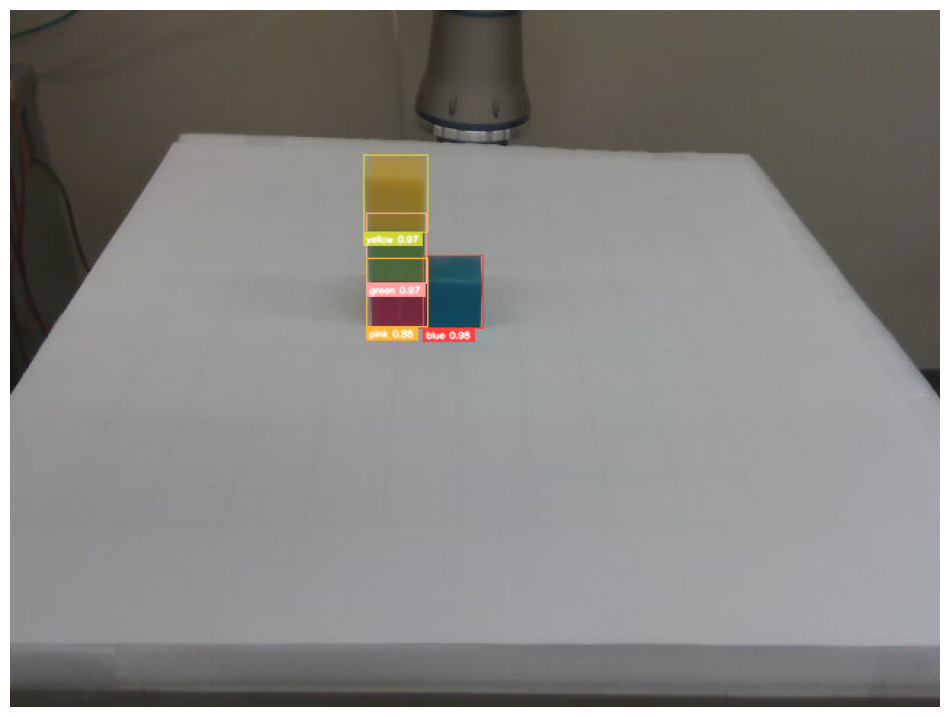

In [8]:
img_folder = os.path.join(os.getcwd(), 'task_images_tiny')
img_name = '2024-05-29-150442_18.jpg' # Example image with a typical blocks configuration on the table
img_path = os.path.join(img_folder, img_name)
yolo_res = yolo_for_llm_lst(img_path, show_image=True)

In [9]:
# The LLM would receive the following 'language' input to reason about the blocks positions
yolo_res

[{'class': 'blue block',
  'x_min': 285,
  'y_min': 170,
  'x_max': 326,
  'y_max': 219},
 {'class': 'yellow block',
  'x_min': 244,
  'y_min': 100,
  'x_max': 287,
  'y_max': 153},
 {'class': 'green block',
  'x_min': 245,
  'y_min': 141,
  'x_max': 287,
  'y_max': 188},
 {'class': 'pink block',
  'x_min': 246,
  'y_min': 171,
  'x_max': 288,
  'y_max': 218}]

### 2) Understanding of YOLO results (text) by LLM

An LLM takes in the previous object detection text to give us an interpretation of how the objects are positioned with respect to each other. The LLM instructions must be carefully designed. We "encourage" the LLM to go through a great amount of reasoning, to ensure that it makes no mistakes. The answer will be quite lengthy.

In [10]:
yolo_interpretation = llm_interpret_yolo(str(yolo_res))
# Translate the YOLO results into a human-readable format, because now it is in Markdown
from IPython.display import display, Markdown
display(Markdown(yolo_interpretation))

### Column Analysis

1. **Column 1:**
   - **Yellow Block:** (x_min: 244, y_min: 100, x_max: 287, y_max: 153)
   - **Green Block:** (x_min: 245, y_min: 141, x_max: 287, y_max: 188)
   - **Pink Block:** (x_min: 246, y_min: 171, x_max: 288, y_max: 218)

2. **Column 2:**
   - **Blue Block:** (x_min: 285, y_min: 170, x_max: 326, y_max: 219)

### Row Analysis

1. **Row 1:**
   - **Yellow Block:** (x_min: 244, y_min: 100, x_max: 287, y_max: 153)

2. **Row 2:**
   - **Green Block:** (x_min: 245, y_min: 141, x_max: 287, y_max: 188)

3. **Row 3:**
   - **Pink Block:** (x_min: 246, y_min: 171, x_max: 288, y_max: 218)
   - **Blue Block:** (x_min: 285, y_min: 170, x_max: 326, y_max: 219)

### Block Configuration

- The **yellow block** is on top of the **green block**.
- The **green block** is on top of the **pink block**.
- The **pink block** is to the left of the **blue block**.
- The **blue block** is to the right of the **pink block**.

### Overall Shape

The blocks appear to form an "L" shape, with the yellow, green, and pink blocks forming a vertical line and the blue block extending to the right from the bottom of the pink block.

### 3) Summarization of LLM spatial interpretation
We need to summarize the previous answer, because it is too long, and there might be many of such inputs being frequently relayed to the main chatbot. This shortening could be achieve in various ways; we used a (cheaper/simpler) LLM for this task.

In [11]:
yolo_interp_summary = llm_summarize(yolo_interpretation)
display(Markdown(yolo_interp_summary))

The yellow block is above the green block, which is above the pink block. The pink block is positioned to the left of the blue block, with the blue block to the right of the pink block. Collectively, the blocks create an "L" shape with the vertical arrangement of the yellow, green, and pink blocks and the horizontal extension of the blue block to the right from the pink block.

### 4) Identification of other objects
Additionally (softer requirement) we run a visual LLM taking the *image* (not text), which has instructions to inform us about any other objects that are not the colored blocks, if there are any.

In [12]:
objects_not_blocks = lmm_no_blocks(img_path) # In this example, there are only colored blocks on the table
display(Markdown(objects_not_blocks))

Nothing else to add about the image.

### 5) Integration of "block" and "non-block" information
We integrate the previous two, again with a simple/inexpensive LLM. This is what will be fed as input to the main chatbot whenever it needs to perceive what is on the experiment table.

In [13]:
vision_combined = llm_combine_all(yolo_interp_summary, objects_not_blocks) 
display(Markdown(vision_combined))

The yellow block is above the green block, which is above the pink block. The pink block is positioned to the left of the blue block, with the blue block to the right of the pink block. Collectively, the blocks create an "L" shape with the vertical arrangement of the yellow, green, and pink blocks and the horizontal extension of the blue block to the right from the pink block.

Let us combine the whole vision workflow in a single function:

In [14]:
def visual_processing(image_path):
    yolo_res = yolo_for_llm_lst(image_path, show_image=True) # YOLO is applied to the image. 
    yolo_interpretation = llm_interpret_yolo(str(yolo_res)) # The YOLO results (coordinates of boundind boxes) are interpreted (as text!) by an LLM. The interpretation is very thorough.
    yolo_interp_summary = llm_summarize(yolo_interpretation) # The interpretation is summarized by another LLM. 
    objects_not_blocks = lmm_no_blocks(image_path)  # An LMM that looks into anything else other than the colored blocks.
    vision_combined = llm_combine_all(yolo_interp_summary, objects_not_blocks) # An LLM that combines and summarizes the results of the two LLMs.
    return vision_combined

# Tools for function-calling, and Chatbot

### Tools to be accessed by chatbot
The chatbot agent identifies which tool must be called by reading their descriptions (the string literals)

In [15]:
@tool("search_tool") # Performs RAG using the Tavily API (similar to Wikipedia), when the agent is asked about facts it may not know.
def search_tool(query: str):
    """
    Utilizes the Tavily API to search for a query and return the top result.
    The answers will be short and concise, and they will NOT point to any URLs, nor any additional sources of information.
    """
    print(">>> inside tool SEARCH_TOOL, with query:", query)
    search_tool = TavilySearchResults(max_results=1)
    answer = search_tool.invoke(query)

    return answer


@tool("vision") # Tool used to process the current image. It uses the function we previously defined, which includes the whole pipeline of YOLO and LLMs.
def vision(query: str):
    """
    This tool is ALWAYS USED WHEN THE USER ASKS EXPLICIT questions about the current image, the robot's vision, what is on the table, etc. 
    """
    print(">>> inside tool VISION, with query:", query)
    image_path_now = get_current_image()
    vision_result = visual_processing(image_path_now)
    
    return vision_result


@tool("pointing") # In this adaptation, there is no robot to point at the blocks. Instead, the tool will draw an arrow pointing at the block in question.
def pointing(query: str):
    """ 
    Use this tool any time the user asks you DIRECTLY or INDIRECTLY to point at a specific block.  
    """
    chatbot_instruction = query
    print(">>> inside tool POINTING, with query: ", chatbot_instruction)
    image_path_now = get_current_image()
    yolo_res = yolo_for_llm_lst(image_path_now)
    bbox_to_point = eval(llm_interpret_yolo(str(yolo_res), instructions=chatbot_instruction)) 
    print(type(bbox_to_point))
    print("bbox_to_point: ", bbox_to_point)
    arrow_point(image_path_now, (bbox_to_point['x_max'] + bbox_to_point['x_min']) // 2, bbox_to_point['y_min'])

    return "" 

In [16]:
tools = [search_tool, vision, pointing]

### Chatbot 
Main agent, also responsible for function-calling

Instructions for the chatbot. These instructions were adapted for the demonstration at the AI Innovators event. 

In [17]:
system_prompt = """ You are a helpful AI assistant. You have some tools at your disposal that you can use when the user explicitly asks you to use them, or if you need them to answer a question. 

You and the user are in a research lab, in front of an experiment table, where there will be objects like colored cubes, etc. 
You might observe different images with different block configurations. If the configurations changed, it's BECAUSE SOMEONE HAD MOVED THE BLOCKS.
All this will be accessed through a camera, whose images will be available to the whole system you're part of.

Many people are watching you, as part of the 'AI Innovators' group. You may want to impress them by quizzing them about the objects on the table, or by asking them questions about anything else.
But remember, your main goal is to help the user answering questions about the objects on the table, or pointing at them, etc.

You will answer to the user's questions, which might not always be directly related to the task at hand, but you will always try to steer the conversation back to the task.

Don't answer in Markdown, but in plain text.
"""

##### LangGraph definition of chatbot node ("agent")

In [18]:
openai_model_version = "gpt-4o" # This model name points always to the latest version of the model
llm = ChatOpenAI(model=openai_model_version)

# Chatbot agent and corresponding node
chatbot_agent = create_chatbot(
    llm,
    tools,
    system_prompt=system_prompt
)
chatbot_node = functools.partial(chatbot_node, agent=chatbot_agent, name="chatbot")

##### Instantiating the graph that includes the chatbot and another node that can execute the tools

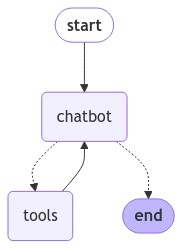

In [19]:
tool_node = BasicToolNode(tools=tools)
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot_node)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    {"tools": "tools", "__end__": "__end__"},
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

conn = sqlite3.connect(":memory:", check_same_thread=False)  
memory = SqliteSaver(conn)
graph = graph_builder.compile(
    checkpointer=memory,
)

config = {"configurable": {"thread_id": "1"}}  # Specify the thread in which "the messages are saved"

try:
    display(Image(graph.get_graph().draw_mermaid_png())) # Displays the graph in LangGraph. 
except:
    # This requires some extra dependencies and is optional
    pass

# INTERACTION

Interaction via speech recognition and audio, or by typing

In [20]:
tts = True # Text-to-speech
speech_recognition = True # Speech recognition

### Interaction loop
We will go through an example interaction to show some of the capabilities of the system.

USER INPUT: hello my name is Jorge and my hobby is diving
content='hello my name is Jorge and my hobby is diving' id='d5f9cb62-6a37-494f-b00f-657663deff81'
> inside CHATBOT node
content="Hi Jorge! Diving sounds like an incredible hobby. The underwater world must be fascinating. Speaking of fascinating things, we're here to explore some interesting configurations on our experiment table. Are you ready to dive into that?" additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 399, 'total_tokens': 442}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_25624ae3a5', 'finish_reason': 'stop', 'logprobs': None} name='chatbot' id='run-3720c3d2-afe5-4d06-bf4b-6be880398e18-0' usage_metadata={'input_tokens': 399, 'output_tokens': 43, 'total_tokens': 442}
Response.content:  Hi Jorge! Diving sounds like an incredible hobby. The underwater world must be fascinating. Speaking of fascinating things, we're here to explore some interes

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.



0: 480x640 1 blue, 1 pink, 1 yellow, 74.8ms
Speed: 2.9ms preprocess, 74.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


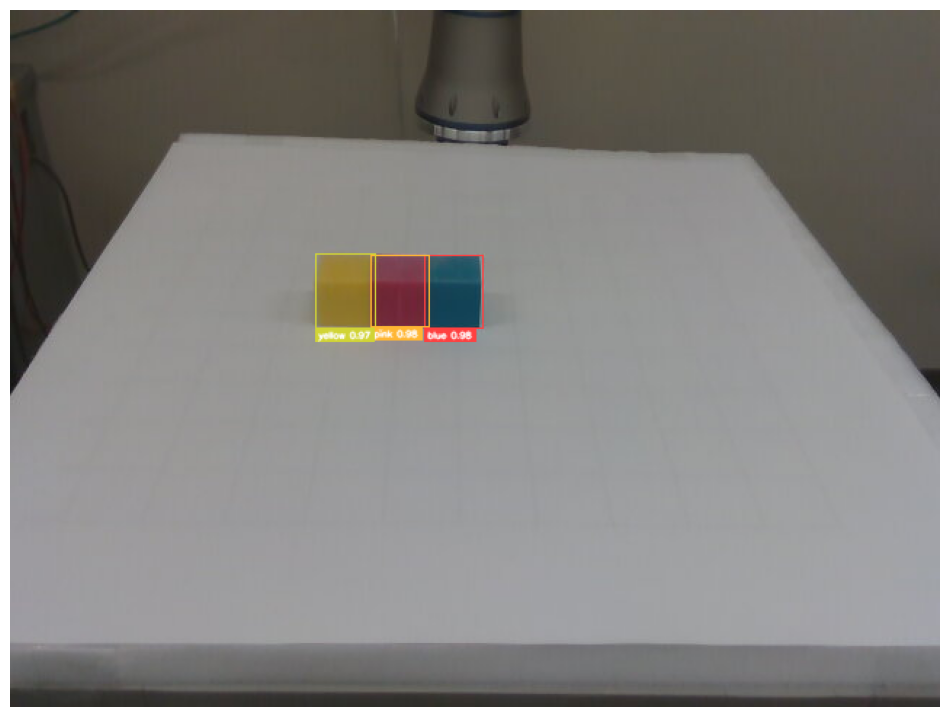

content='"The Yellow block is to the left of the Pink block, which is to the left of the Blue block. All blocks are situated on the same horizontal plane and are aligned in a straight line. Nothing else to add about the image."' name='vision' id='b596b015-70e5-4b5f-a594-03c7fab11494' tool_call_id='call_dubYpaVzzh6kzITJ3vzOX2bC'
> inside CHATBOT node
content='On the table, I can see three blocks: a Yellow block, a Pink block, and a Blue block. They are all aligned in a straight line, with the Yellow block on the left, the Pink block in the middle, and the Blue block on the right.\n\nIs there anything specific you would like to do or know about these blocks?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 71, 'prompt_tokens': 532, 'total_tokens': 603}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_25624ae3a5', 'finish_reason': 'stop', 'logprobs': None} name='chatbot' id='run-92f8a318-5aec-4d22-aaca-a969f235f65f-0' usage_metadata

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.



0: 480x640 1 blue, 1 green, 1 pink, 1 yellow, 74.8ms
Speed: 1.3ms preprocess, 74.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


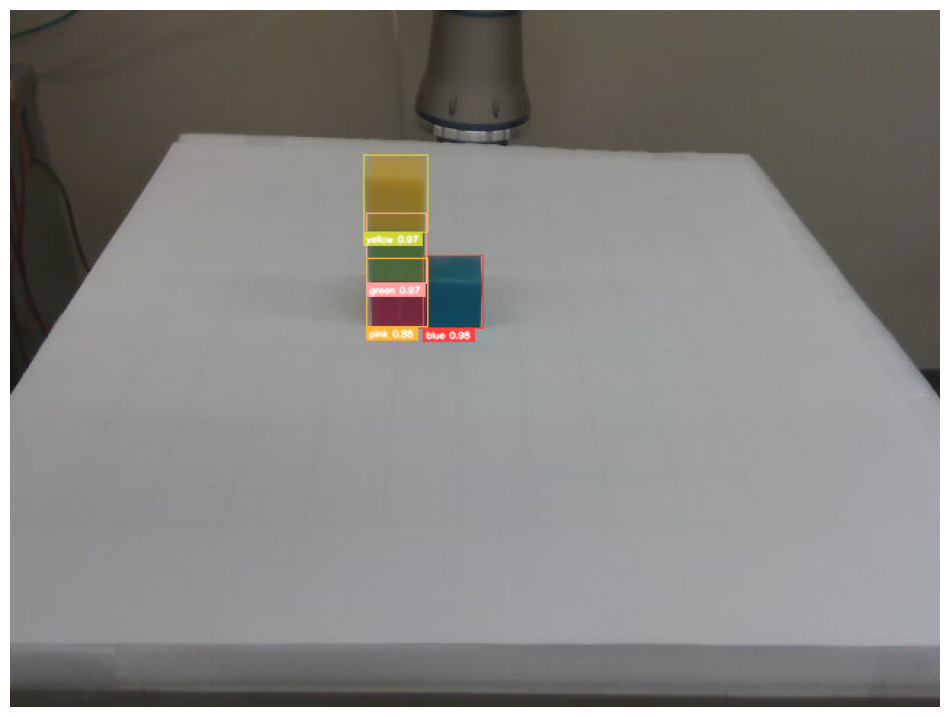

content='"The yellow block is directly above the green block, which is directly above the pink block in a vertical stack. The pink block is to the left of the blue block, which is positioned to the right of the pink block, resulting in an \\"L\\" shape. Nothing else to add about the image."' name='vision' id='ca9567ac-9427-44a0-aaad-2b35afc2da50' tool_call_id='call_JH6iTA6XSIfakQHOtQtITmyS'
> inside CHATBOT node
content='Now, the arrangement of the blocks has changed. The Yellow block is directly above the Green block, which is directly above the Pink block, forming a vertical stack. The Pink block is to the left of the Blue block, creating an "L" shape with the vertical stack.\n\nIs there anything specific you would like to do or know about these blocks in this new configuration?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 76, 'prompt_tokens': 708, 'total_tokens': 784}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_25624a

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.



0: 480x640 1 blue, 1 green, 1 pink, 1 yellow, 78.7ms
Speed: 1.4ms preprocess, 78.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)
<class 'dict'>
bbox_to_point:  {'class': 'blue block', 'x_min': 285, 'y_min': 170, 'x_max': 326, 'y_max': 219}


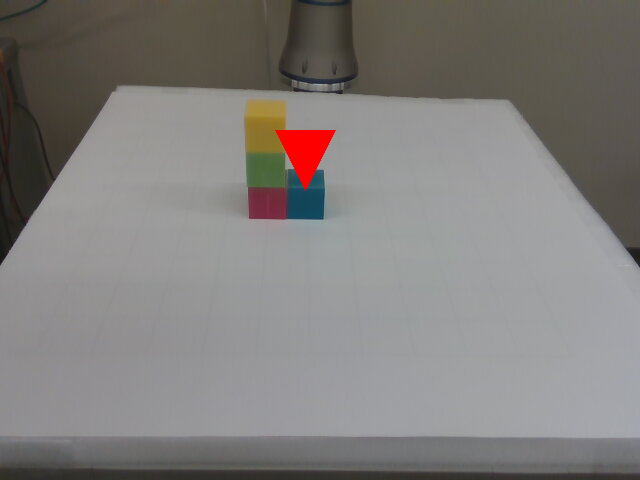

content='""' name='pointing' id='a88194ee-15cc-4767-8a13-83f5670e7ebe' tool_call_id='call_1rvPvlxGZUsDiE1uD1Obykql'
> inside CHATBOT node
content="I've pointed at the Blue block. The color blue often reminds people of the ocean and water, which relates to your hobby of diving." additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 832, 'total_tokens': 860}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_25624ae3a5', 'finish_reason': 'stop', 'logprobs': None} name='chatbot' id='run-da1133fe-dab8-4163-a728-83a45229b55a-0' usage_metadata={'input_tokens': 832, 'output_tokens': 28, 'total_tokens': 860}
Response.content:  I've pointed at the Blue block. The color blue often reminds people of the ocean and water, which relates to your hobby of diving.
USER INPUT: by the way who is the most popular diver in history
content='by the way who is the most popular diver in history' id='dac1499c-38a2-40ac-913c-22a33e500912'
> in

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.



0: 480x640 1 blue, 1 green, 1 pink, 1 yellow, 79.9ms
Speed: 1.4ms preprocess, 79.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


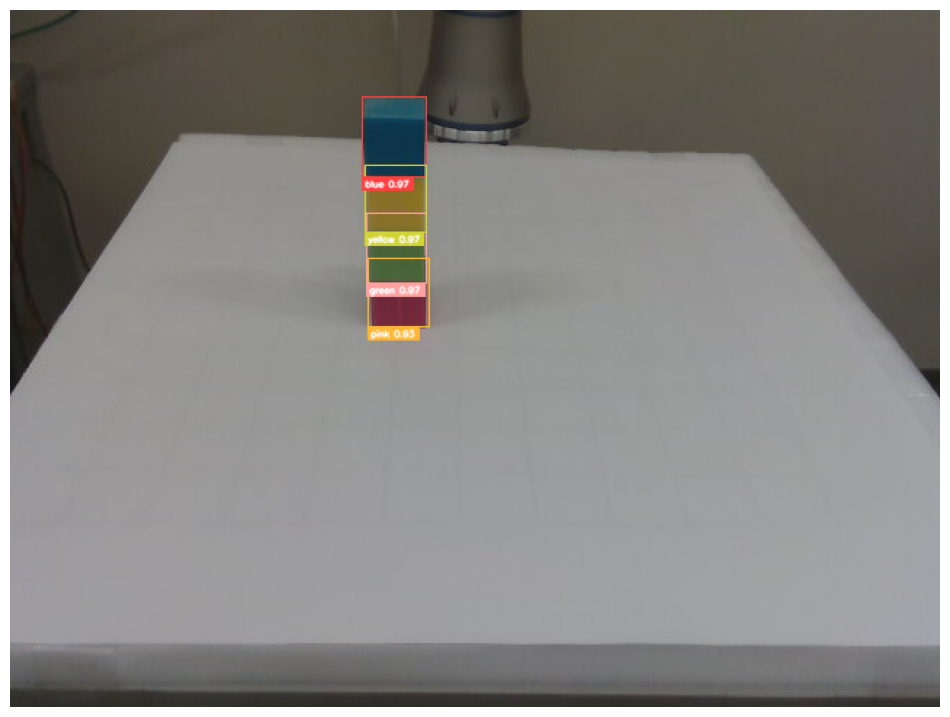

content='"The blue block is located at the top, followed directly below by the yellow block. The green block sits below the yellow block, and the pink block is positioned beneath the green block, creating a vertical column of blocks. Nothing else to add about the image."' name='vision' id='a4b1fdd3-44f0-45c5-b077-88c9c840ba67' tool_call_id='call_IeazFeGXU1dHE1VdHGsTGHlH'
> inside CHATBOT node
content='Yes, the table has changed. Now, there is a vertical column of blocks:\n\n1. Blue block at the top\n2. Yellow block directly below the Blue block\n3. Green block below the Yellow block\n4. Pink block at the bottom of the column\n\nWould you like to do anything specific with this new configuration?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 68, 'prompt_tokens': 1165, 'total_tokens': 1233}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_25624ae3a5', 'finish_reason': 'stop', 'logprobs': None} name='chatbot' id='run-29d85695-36b8

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.



0: 480x640 (no detections), 81.5ms
Speed: 2.5ms preprocess, 81.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


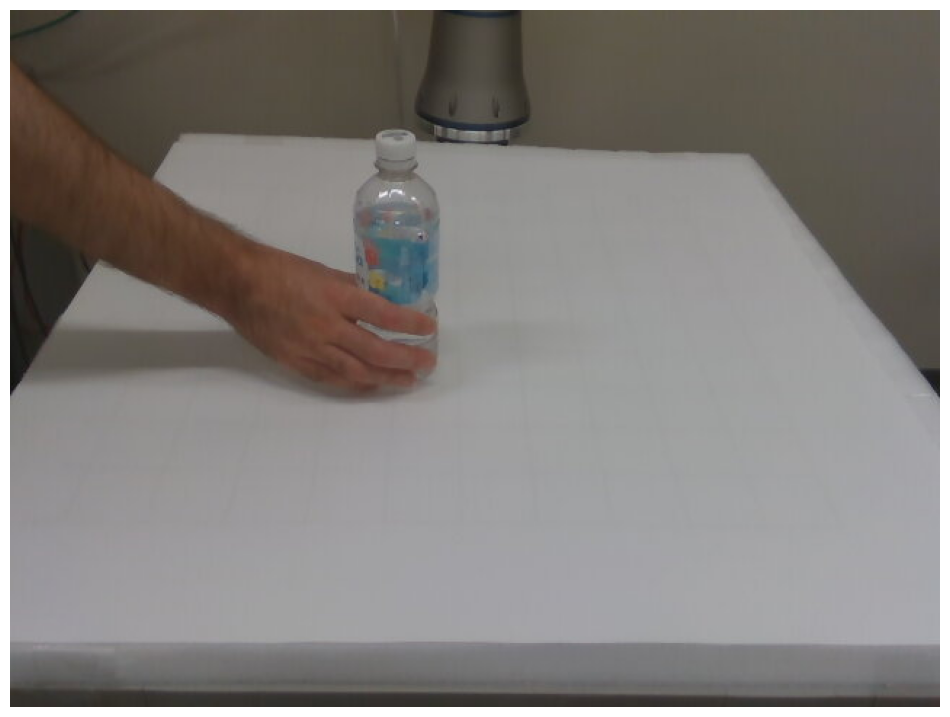

content='"A hand is reaching for a plastic water bottle on the table, and there are no blocks present, leading to no spatial relationships or analyses of rows and columns."' name='vision' id='95a8b567-4515-4e2e-8e2e-12fe5a788c4d' tool_call_id='call_Xt9IJmnKBWgTPBM5apXFDSPU'
> inside CHATBOT node
content='The table has changed again. Now, there are no blocks present. Instead, a hand is reaching for a plastic water bottle on the table.\n\nIs there anything else you would like to know or do?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 1312, 'total_tokens': 1354}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_25624ae3a5', 'finish_reason': 'stop', 'logprobs': None} name='chatbot' id='run-942a2415-f100-4f93-8732-b81577786752-0' usage_metadata={'input_tokens': 1312, 'output_tokens': 42, 'total_tokens': 1354}
Response.content:  The table has changed again. Now, there are no blocks present. Instead, a hand is r

In [21]:
while True:
    
    if  speech_recognition:
        user_input = voice_recog.record_audio()
    else:
        user_input = input("User: ")
    if  user_input.lower() in ["quit", "exit", "q", "finish program"]:
        print("Goodbye!")
        if tts:
            text_to_speech("Goodbye!")
        break

    try:
        for event in graph.stream({"messages": [("user", user_input)]}, config, stream_mode="values"):
            response = event["messages"][-1]
            print(event["messages"][-1])
    except  Exception as e:
        print("Error in graph.stream: ", e)

    try:
        print("Response.content: ", response.content) 
        if isinstance(response, langchain_core.messages.ai.AIMessage):
            if tts:
                text_to_speech(response.content)
            else:
                event["messages"][-1].pretty_print()
    except:
        pass

In [ ]:
# graph.get_state(config) 